# Draw maps for sce

In [9]:
import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_rgba

## Read files

In [2]:
# Import England LSAO Shape file (use 'zip://'' prefix for zip files)
filename = "zip://./Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip"
lsoa_gdf = geopandas.read_file(filename, crs='EPSG:27700')
data = pd.read_csv('results.csv')

demographics = pd.read_csv('../data/collated_data_amb_census.csv')
density = demographics[['LSOA', 'Number of persons per heactre']]
data = data.merge(density, left_on='LSOA', right_on='LSOA', how='left')



<Axes: >

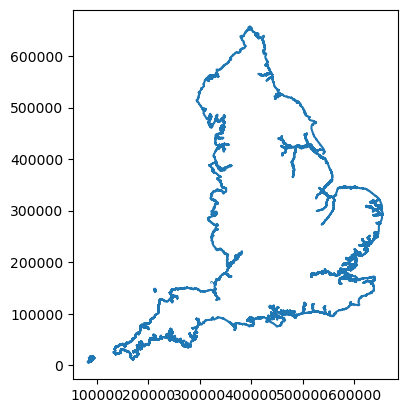

In [3]:
filename = "zip://./Countries_(December_2022)_GB_BFC.zip"
countries_gdf = geopandas.read_file(filename, crs='EPSG:27700')
mask = countries_gdf['CTRY22NM'] == 'England'
countries_gdf = countries_gdf[mask]
# Get outline of countries_gdf
england = countries_gdf.boundary
england.plot()


In [4]:
# Add net benefit column
prop_nlvo = 0.7
prop_lvo = 1 - prop_nlvo

# Utility

data['drip_ship_utility_shift'] = (
    (data['nlvo_drip_ship_ivt_utility_shift'] * prop_nlvo) +
    (data['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo))

data['mothership_utility_shift'] = (
    (data['nlvo_mothership_ivt_utility_shift'] * prop_nlvo) +
    (data['lvo_mothership_ivt_mt_utility_shift'] * prop_lvo))

data['msu_utility_shift'] = (
    (data['nlvo_msu_ivt_utility_shift'] * prop_nlvo) +
    (data['lvo_msu_ivt_mt_utility_shift'] * prop_lvo))

data['msu_net_utility_benefit'] = data['msu_utility_shift'] - data['drip_ship_utility_shift']

# Get mRS 0-2 improvements
data['nlvo_drip_ship_ivt_improvement_over_no_treatment'] = \
    data['nlvo_drip_ship_ivt_mrs_0-2'] - data['nlvo_no_treatment_mrs_0-2']
data['nlvo_msu_ivt_improvement_over_no_treatment'] = \
    data['nlvo_msu_ivt_mrs_0-2'] - data['nlvo_no_treatment_mrs_0-2']
data['lvo_drip_ship_ivt_improvement_over_no_treatment'] = \
    data['lvo_drip_ship_ivt_mrs_0-2'] - data['lvo_no_treatment_mrs_0-2']
data['lvo_msu_ivt_improvement_over_no_treatment'] = \
    data['lvo_msu_ivt_mrs_0-2'] - data['lvo_no_treatment_mrs_0-2']


# Get proportions mRS 0-2 for each scenario
data['no_treatment_mrs_0-2'] = (
    (data['nlvo_no_treatment_mrs_0-2'] * prop_nlvo) +
    (data['lvo_no_treatment_mrs_0-2'] * prop_lvo))

data['drip_ship_mrs_0-2'] = (
    (data['nlvo_drip_ship_ivt_mrs_0-2'] * prop_nlvo) +
    (data['lvo_drip_ship_mt_mrs_0-2'] * prop_lvo))

data['drip_ship_mrs_0-2_improvement_over_no_treatment'] = \
    data['drip_ship_mrs_0-2'] - data['no_treatment_mrs_0-2']

data['mothership_mrs_0-2'] = (
    (data['nlvo_mothership_ivt_mrs_0-2'] * prop_nlvo) +
    (data['lvo_mothership_ivt_mt_mrs_0-2'] * prop_lvo))

data['mothership_mrs_0-2_improvement_over_no_treatment'] = \
    data['mothership_mrs_0-2'] - data['no_treatment_mrs_0-2']

data['msu_mrs_0-2'] = (
    (data['nlvo_msu_ivt_mrs_0-2'] * prop_nlvo) +
    (data['lvo_msu_ivt_mt_mrs_0-2'] * prop_lvo))

data['msu_mrs_0-2_improvement_over_no_treatment'] = \
    data['msu_mrs_0-2'] - data['no_treatment_mrs_0-2']


data['msu_mrs_0-2_benefit'] = data['msu_mrs_0-2'] - data['drip_ship_mrs_0-2']

data['nlvo_msu_ivt_utility_benefit'] = data['nlvo_msu_ivt_utility'] - data['nlvo_drip_ship_ivt_utility']
data['lvo_msu_ivt_utility_benefit'] = data['lvo_msu_ivt_utility'] - data['lvo_drip_ship_ivt_utility']
data['lvo_msu_ivt_mt_utility_benefit'] = data['lvo_msu_ivt_mt_utility'] - data['lvo_drip_ship_ivt_mt_utility']
data['nlvo_msu_ivt_mrs_0-2_benefit'] = data['nlvo_msu_ivt_mrs_0-2'] - data['nlvo_drip_ship_ivt_mrs_0-2']
data['lvo_msu_ivt_mrs_0-2_benefit'] = data['lvo_msu_ivt_mrs_0-2'] - data['lvo_drip_ship_ivt_mrs_0-2']
data['lvo_msu_ivt_mt_mrs_0-2_benefit'] = data['lvo_msu_ivt_mt_mrs_0-2'] - data['lvo_drip_ship_ivt_mt_mrs_0-2']

In [5]:
# Merge the data with the LSOA shapefile
data = lsoa_gdf.merge(data, left_on='LSOA11NM', right_on='LSOA', how='right')

In [6]:
hospitals_gdf = geopandas.read_file('stroke_hospitals.csv')
hospitals_gdf.geometry = geopandas.points_from_xy(
        hospitals_gdf.long, hospitals_gdf.lat)
# Set crs for geometry, using epsg4326 for lat/long
hospitals_gdf = hospitals_gdf.set_crs(epsg=4326)
# Convert to British National Grid
hospitals_gdf = hospitals_gdf.to_crs(epsg=27700)
hospitals_gdf.head()
mask = hospitals_gdf['Country'] == 'England'
hospitals_gdf = hospitals_gdf[mask]

greedy = pd.read_csv('greedy.csv')
hospitals_gdf =  hospitals_gdf.merge(greedy, on='Hospital_name', how='left')

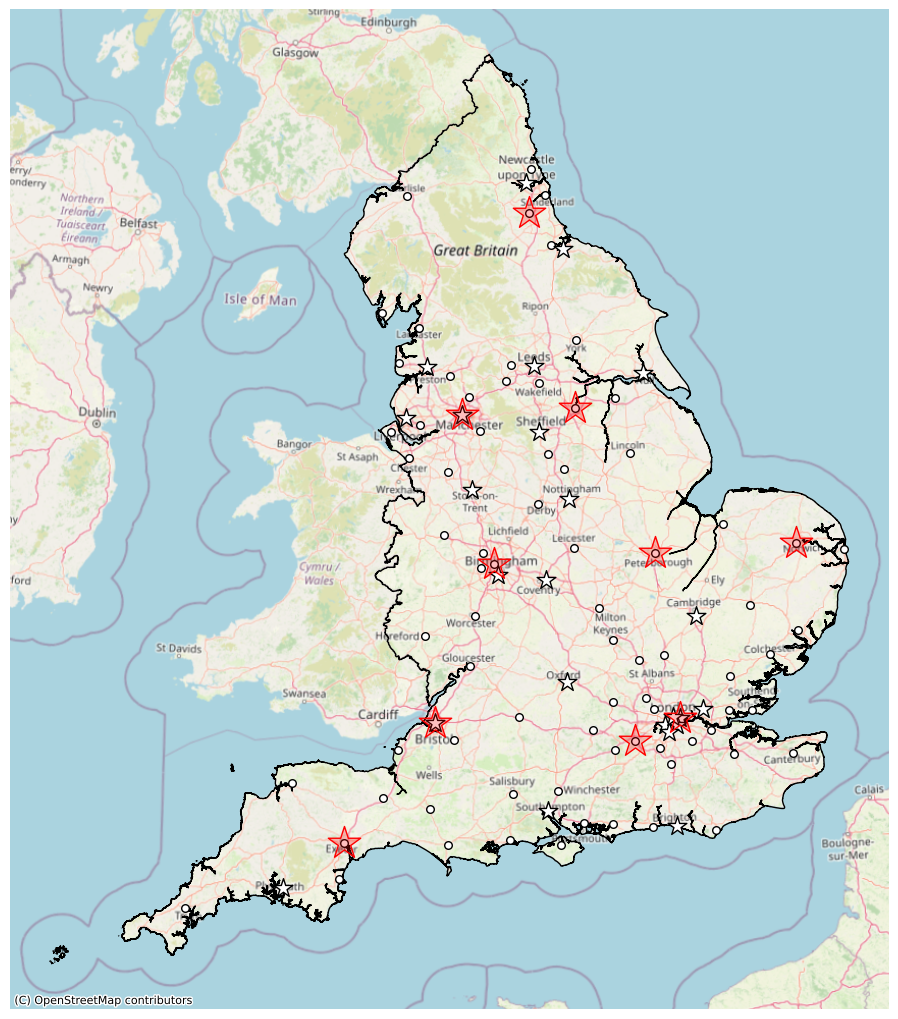

In [13]:
fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
"""
data.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column='msu_mrs_0-2_benefit', # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 vmin=-0.04, # Manual scale min (remove to make automatic)
                 vmax=0.04, # Manual scale max (remove to make automatic)
                 cmap='seismic_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':' '},
                 # Set to display legend
                 legend=True,
                 # Make slightly transparent
                 alpha=1)
#ax.set_axis_off() # Turn of axis linea dn numbers
"""
# Plot outline
england.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=1)

# Plot location of hospitals
mask = hospitals_gdf['Use_IVT'] == '1'
hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=30, marker='o', zorder=99)
mask = hospitals_gdf['Use_MT'] == '1'
hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=200, marker='*', zorder=99)

# Get top 10 MSU sites (greedy)
mask = hospitals_gdf['order'] <= 10
hospitals_gdf[mask].plot(ax=ax, edgecolor='r', facecolor=to_rgba('r', alpha=0.25), markersize=600, marker='*', zorder=99)


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:27700')
#ax.set_axis_off() # Turn of axis line numbers
ax.set_axis_off() 
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)

plt.savefig('map.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1) # Save figure
plt.show()